#Initial data input and cleaning

In [1]:
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split

In [2]:
with open('sentences_merged_training.pkl',"rb") as f:
    df = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
df.info()

In [ ]:
df['emotions'].value_counts()

In [ ]:
df.head()

In [ ]:
df = df.dropna()
df['text'] = df['text'].astype('string')
# df.count()[0]

In [ ]:
df['word_count'] = [len(i.split()) for i in df['text']]
df['text_length'] = [len(i) for i in df['text']]
df['avg_word_length'] = [sum(len(j) for j in i.split())/len(i.split()) for i in df['text']]
df['i_count'] = [i.count('i') for i in df['text']]
df['e_count'] = [i.count('e') for i in df['text']]
df['ive_rate'] = [i.count('ive')/(len(i)/3) for i in df['text']]
df['im_rate'] = [i.count('im')/(len(i)/2) for i in df['text']]
df['me_rate'] = [i.count('me')/(len(i)/2) for i in df['text']]
df['feel_rate'] = [i.count('feel')/(len(i)/4) for i in df['text']]
# df['sadness'] = [1 if i=='sadness' else 0 for i in df['emotions']]
df = pd.concat([df, pd.get_dummies(df['emotions'], prefix='emotion')], axis=1)
# df = df.drop(columns='emotions')
df.head()

In [ ]:
import math

def print_upperlower95(p,n):
  conf_inv = 1.96 * math.sqrt((p * (1 - p)) / n)
  print('Lower: ', (p - conf_inv), ' | Upper: ', (p + conf_inv))

#Quantitative Output Models
---
---

##Linear Regression
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'emotion_surprise']
# X = X.drop(columns='e_count')
# y = df.loc[:,'feel_rate']
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
import statsmodels.api as sm

lin = sm.OLS.from_formula(
    'feel_rate ~ word_count + text_length + avg_word_length + i_count + e_count + ' +
    'ive_rate + im_rate + me_rate + emotion_anger + emotion_fear + emotion_joy + ' +
    'emotion_love + emotion_sadness + emotion_surprise', X_train)
result = lin.fit()

###Results

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              feel_rate   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                 3.305e+04
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        04:49:50   Log-Likelihood:             8.0242e+05
No. Observations:              375128   AIC:                        -1.605e+06
Df Residuals:                  375114   BIC:                        -1.605e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1176      0.001    218.465      0.000       0.117       0.119
word_count          -0.0013   4.31e-05    -31.260      0.000      -0.001      -0.001
text_length         -0.0004   9.09e-06    -40.202      0.000      -0.000      -0.000
avg_word_length     -0.0061      0.000    -41.479      0.000      -0.006      -0.006
i_count              0.0001   2.33e-05      4.981      0.000    7.05e-05       0.000
e_count              0.0010   1.89e-05     50.382      0.000       0.001       0.001
ive_rate            -0.0424      0.003    -12.190      0.000      -0.049      -0.036
im_rate              0.1522      0.003     51.374      0.000       0.146       0.158
me_rate             -0.1481      0.003    -55.135      0.000      -0.153      -0.143
emotion_anger        0.0191      0.000    128.461      0.000       0.019       0.019
emotion_fear         0.0194      0.000    122.881      0.000       0.019       0.020
emotion_joy          0.0190      0.000    154.963      0.000       0.019       0.019
emotion_love         0.0183      0.000    107.115      0.000       0.018       0.019
emotion_sadness      0.0221      0.000    174.788      0.000       0.022       0.022
emotion_surprise     0.0198      0.000     85.131      0.000       0.019       0.020
==============================================================================
Omnibus:                   155064.664   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1076708.444
Skew:                           1.845   Prob(JB):                         0.00
Kurtosis:                      10.434   Cond. No.                     5.55e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.62e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
X.mean()

word_count          19.211015
text_length         97.028397
avg_word_length      4.147386
i_count              6.828747
e_count             10.610316
ive_rate             0.004061
im_rate              0.007819
me_rate              0.011383
feel_rate            0.061205
emotion_anger        0.137514
emotion_fear         0.114470
emotion_joy          0.338445
emotion_love         0.082901
emotion_sadness      0.290749
emotion_surprise     0.035921
dtype: float64

In [ ]:
def predict_get_intervals(res, new):
    
    # Get the predicted values
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    
    # Get the confidence interval for the model (and rename the columns to something a bit more useful)
    ci = res.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # Now a little bit of matrix multiplication to get the confidence intervals for the predictions
    ci = ci.T.dot(new.T).T
    
    # And finally wrap up the confidence intervals with the predicted values
    return pd.concat([fit, ci], axis=1)

new = pd.DataFrame([[1, 19, 97, 4, 6, 10, 0.004061, 0.007819, 0.011383, 
                     1, 0, 0, 0, 0, 0]], 
                   columns=['Intercept', 'word_count', 'text_length', 
                            'avg_word_length', 'i_count', 'e_count',
                            'ive_rate', 'im_rate', 'me_rate', 'emotion_anger',
                            'emotion_fear', 'emotion_joy', 'emotion_love',
                            'emotion_sadness', 'emotion_surprise'])
predict_get_intervals(result, new)

,fit,lower,upper
0,0.06088,0.054269,0.06749


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


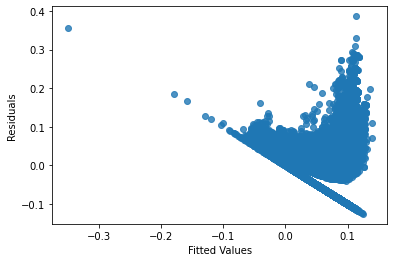

In [ ]:
fitted_values = pd.Series(result.fittedvalues, name="Fitted Values")
residuals = pd.Series(result.resid, name="Residuals")
sns.regplot(fitted_values, residuals, fit_reg=False)

##Lasso Regression
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'emotion_sadness']
X = X.drop(columns='feel_rate')
y = df.loc[:,'feel_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
lasso = lm.LassoCV(cv=5, random_state=0).fit(X_train,y_train)

###Results

In [ ]:
lasso.score(X,y)

0.5243002875106619

In [ ]:
lasso.coef_

array([-0.        , -0.00057695, -0.        ,  0.        ,  0.00041837,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ])

##Ridge Regression
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'emotion_sadness']
X = X.drop(columns='feel_rate')
y = df.loc[:,'feel_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
ridge = lm.RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train,y_train)

###Results

In [ ]:
ridge.score(X,y)

0.533533798197884

In [ ]:
ridge.coef_

array([-1.34825638e-03, -3.65316957e-04, -6.09108043e-03,  1.16396770e-04,
        9.54195523e-04, -4.23488944e-02,  1.52014336e-01, -1.47955413e-01,
       -6.64418052e-04, -3.63750847e-04, -7.39945253e-04, -1.45230632e-03,
        2.32770083e-03])

##Decision Tree
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'emotion_sadness']
X = X.drop(columns='feel_rate')
y = df.loc[:,'feel_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_leaf_nodes=10)
regr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

###Results

In [ ]:
from sklearn import metrics
# Score/print
print('Score: ', regr.score(X_test, y_test))

y_predicted = regr.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_predicted)
print('MAE: ', mae)

Score:  0.8442115984150653
MAE:  0.00824491644759066


#Binary Output Models
---
---

##Logistic Regression
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'feel_rate']
y = df.loc[:,'emotion_sadness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
## This is without cross validation
# import sklearn.linear_model as skl_lm
# regr = skl_lm.LogisticRegression()
# regr.fit(X_train, y_train)

from sklearn.linear_model import LogisticRegressionCV
regr_cv = LogisticRegressionCV(cv=10, random_state=0, solver='lbfgs', Cs = [np.inf]).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


###Results

In [ ]:
## Without CV ##
# pred = regr.predict(X_test)

# print(classification_report(y_test, pred))
# print(np.count_nonzero(pred))
# print(len(pred))

## With CV ##
np.max(regr_cv.scores_[1])

0.7098872390904486

In [ ]:
def binarizer(n): 
    if n[1] > 0.8:
      return 1
    else:
      return 0
  
ypre = regr_cv.predict_proba(X_test).tolist()
ybin = list(map(binarizer, ypre))
sum([ybin[i] == y_test.values[i] for i in range(len(y_test))]) / len(y_test)

0.7057412250185936

In [ ]:
pred = regr_cv.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83     29416
           1       0.57      0.01      0.01     12265

    accuracy                           0.71     41681
   macro avg       0.64      0.50      0.42     41681
weighted avg       0.67      0.71      0.59     41681



In [ ]:
print_upperlower95(np.max(regr_cv.scores_[1]), len(pred))

Lower:  0.7055304643390853  | Upper:  0.7142440138418119


##Support Vector Machine
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'feel_rate']
y = df.loc[:,'emotion_sadness']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=42)

###Setup and fit model (and Results)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=3, scoring='accuracy', return_train_score=True)
#clf = SVC(kernel='rbf', C=1, gamma=2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7092222631063781

In [ ]:
clf.best_params_

{'C': 0.01, 'gamma': 0.5}

In [ ]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'degree': [1,2,3,4]}]
clf2 = GridSearchCV(SVC(kernel='poly'), tuned_parameters, cv=3, scoring='accuracy', return_train_score=True)
clf2.fit(X_train, y_train)
clf2.score(X_test, y_test)

0.7092222631063781

In [ ]:
clf2.best_params_

{'C': 0.01, 'degree': 1}

In [ ]:
tuned_parameters = [{'C': [0.01, 0.1, 1, 5]}]
clf3 = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=3, scoring='accuracy', return_train_score=True)
clf3.fit(X_train, y_train)
clf3.score(X_test, y_test)

0.7092222631063781

In [ ]:
clf3.best_params_

{'C': 0.01}

In [ ]:
1 - (sum(y_test) / len(y_test))

0.7092222631063781

#Categorical Output Models
---
---

##K-Nearest Neighbors
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'feel_rate']
y = df.loc[:,'emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
from sklearn import neighbors

neighbor_arr = [(x*2)-1 for x in range(1,30)]
best_score = 0
best_n = 0
for n in neighbor_arr:
  knn = neighbors.KNeighborsClassifier(n_neighbors=n)
  score = knn.fit(X_train, y_train).score(X_test, y_test)
  if (score > best_score):
    best_score = score
    best_n = n
  print('n: ', n, ' | score: ', score)

print('Best n: ', best_n)
print('Score: ', best_score)

knn = neighbors.KNeighborsClassifier(n_neighbors=best_n)
pred = knn.fit(X_train, y_train).predict(X_test)

n:  1  | score:  0.2352150860104124
n:  3  | score:  0.2371584175043785
n:  5  | score:  0.271634557712147
n:  7  | score:  0.28089537199203474
n:  9  | score:  0.2913797653607159
n:  11  | score:  0.2990091408555457
n:  13  | score:  0.3042873251601449
n:  15  | score:  0.30954151771790506
n:  17  | score:  0.3132122549842854
n:  19  | score:  0.3156834049087114
n:  21  | score:  0.3198579688587126
n:  23  | score:  0.3226650032388858
n:  25  | score:  0.3254000623785418
n:  27  | score:  0.32676759194836974
n:  29  | score:  0.33091816415153186
n:  31  | score:  0.33130203210095727
n:  33  | score:  0.33319738010124517
n:  35  | score:  0.33223771022768167
n:  37  | score:  0.3335812480506706
n:  39  | score:  0.33401309949377417
n:  41  | score:  0.33367721503802694
n:  43  | score:  0.3349967611141767
n:  45  | score:  0.3357644970130275
n:  47  | score:  0.33667618339291283
n:  49  | score:  0.33703605959549915
n:  51  | score:  0.33701206784866006
n:  53  | score:  0.336628199899

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=201)
pred = knn.fit(X_train, y_train).predict(X_test)

###Results

In [ ]:
print(classification_report(y_test, pred, digits=3))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger      0.333     0.000     0.000      5688
        fear      1.000     0.000     0.000      4720
         joy      0.348     0.789     0.483     14059
        love      0.000     0.000     0.000      3409
     sadness      0.329     0.262     0.292     12265
    surprise      0.000     0.000     0.000      1540

    accuracy                          0.343     41681
   macro avg      0.335     0.175     0.129     41681
weighted avg      0.373     0.343     0.249     41681



##Linear Discriminant Analysis
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'feel_rate']
y = df.loc[:,'emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

###Results

In [ ]:
print(classification_report(y_test, pred, digits=3))
print(np.unique(pred, return_counts=True))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger      0.000     0.000     0.000      5688
        fear      0.333     0.000     0.001      4720
         joy      0.350     0.833     0.493     14059
        love      0.000     0.000     0.000      3409
     sadness      0.359     0.240     0.288     12265
    surprise      0.000     0.000     0.000      1540

    accuracy                          0.352     41681
   macro avg      0.174     0.179     0.130     41681
weighted avg      0.262     0.352     0.251     41681

(array(['fear', 'joy', 'sadness'], dtype='<U8'), array([    6, 33479,  8196]))


##Quadradic Discriminant Analysis
---

###Setup Inputs

In [ ]:
X = df.loc[:,'word_count':'feel_rate']
y = df.loc[:,'emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

###Setup and fit model

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

###Results

In [ ]:
print(classification_report(y_test, pred, digits=3))
print(np.unique(pred, return_counts=True))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       anger      0.218     0.044     0.073      5688
        fear      0.231     0.002     0.004      4720
         joy      0.356     0.751     0.483     14059
        love      0.085     0.025     0.039      3409
     sadness      0.352     0.282     0.314     12265
    surprise      0.000     0.000     0.000      1540

    accuracy                          0.345     41681
   macro avg      0.207     0.184     0.152     41681
weighted avg      0.287     0.345     0.269     41681

(array(['anger', 'fear', 'joy', 'love', 'sadness'], dtype=object), array([ 1154,    39, 29640,  1017,  9831]))
